# S07 T01: Tasca del test d'hipòtesis
## Luis Pardina - Data Science - 11/05/2022

### *Exercici 1*: Agafa un conjunt de dades de tema esportiu que t'agradi i selecciona un atribut del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_1samp, ttest_ind, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

Vaig a continuar amb la base de dades d'escaladors que vaig utilitzar als dos sprints anteriors.

Resum del contingut i característiques de la base de dades:

A més de nacionalitat, sexe, alçada pes i edat de l'escalador hi ha aquests altres camps:

    years_cl -> years climbing
    date_first -> date of the first ascension
    date_last -> date of the last ascension
    grades_count -> number of routes done by climber
    grades_first -> grade of the first ascension
    grades_last -> grade of the last ascension
    grades_max -> biggest grade achieved by climber in an ascension
    grades_mean -> average of the grades of the climber in ascensions
    year_first -> year of the first ascension
    year_last -> year of the last ascension

El ***grade*** indica la dificultat de l'ascensió, és un número ordinal correlatiu de petit a gran que es correspon amb l'escala del sistema frencès de graduació. Aquest sistema considera la dificultat total de l'escalada. Els graus comencen per l'1 i el sistema no té límit superior.

La base de dades té prop d'11.000 registres. No hi ha camps nuls. Excepte el pais i els camps *date_first* i *date_last*, són tots camps numèrics.

Hi ha tres registres on el camp year_first té un valor inconsistent (0, 0, 1095).
A més, només en 192 dels registres hi ha coincidencia entre els valors de *years_cl* (els anys que l'escalador duu fent ascensions) i la diferencia entre *year_last* (any de la darrera escalada) i *year_first* (any de la primera escalada). Aquests dos darrers camps semblen extrets de *date_first* i *date_last*.

In [2]:
escaladors = pd.read_csv('climber_df.csv')

Presento un histograma dels atributs més relevants del dataframe. La distribució del numero d'ascensions segueix un patró de tipus logaritmic

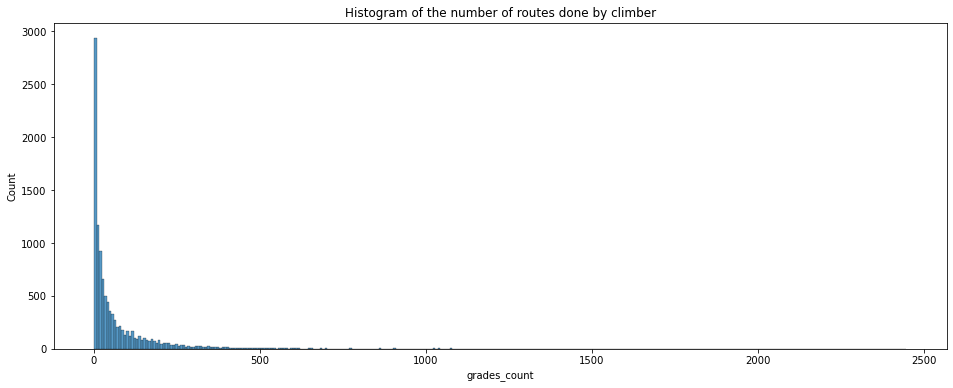

In [3]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors, x='grades_count')
plt.title('Histogram of the number of routes done by climber');
plt.xlabel('grades_count');

L'histograma de grau maxim presenta una forma estranya. Aixó es degut al sistema francés de graduació de les escalades: es pot assignar la dificultat de la ascensió a un grau general que es un número i una lletra (p. exemple, 4c) però després afegir-li un plus o dos (p. exemple, 4c+ o 4c++). Aquestes ascensions amb grau de dificultat una mica particulars son les que provoquen aquesta distorsió a l'histograma. Per corregir-ho amb vistes a l'anàlisi, vaig a fer una agrupació dels graus màxims en grups de 5, em queda una escala propia molt eixerida (Escala Pardina d'ascensions) en graus de dificultat correlatius del 5 al 15.

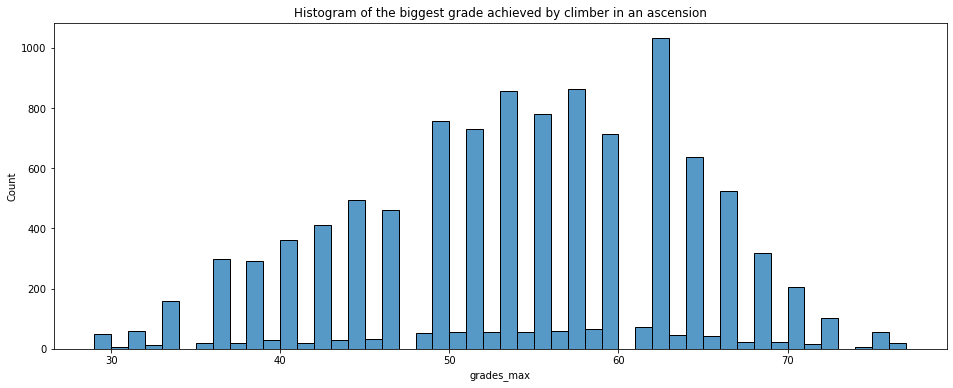

In [4]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors, x='grades_max', binwidth=1)
plt.title('Histogram of the biggest grade achieved by climber in an ascension');
plt.xlabel('grades_max');

In [5]:
escaladors['max_grade'] = escaladors.grades_max//5

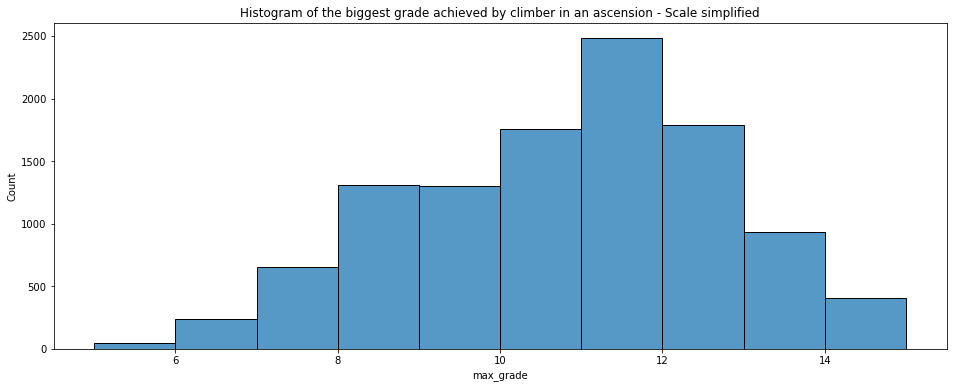

In [6]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors, x='max_grade', binwidth=1)
plt.title('Histogram of the biggest grade achieved by climber in an ascension - Scale simplified');
plt.xlabel('max_grade');

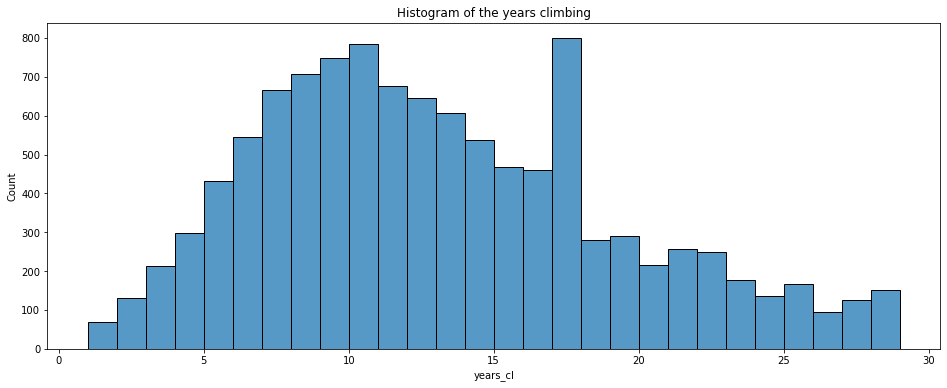

In [7]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors, x='years_cl', binwidth=1)
plt.title('Histogram of the years climbing');
plt.xlabel('years_cl');

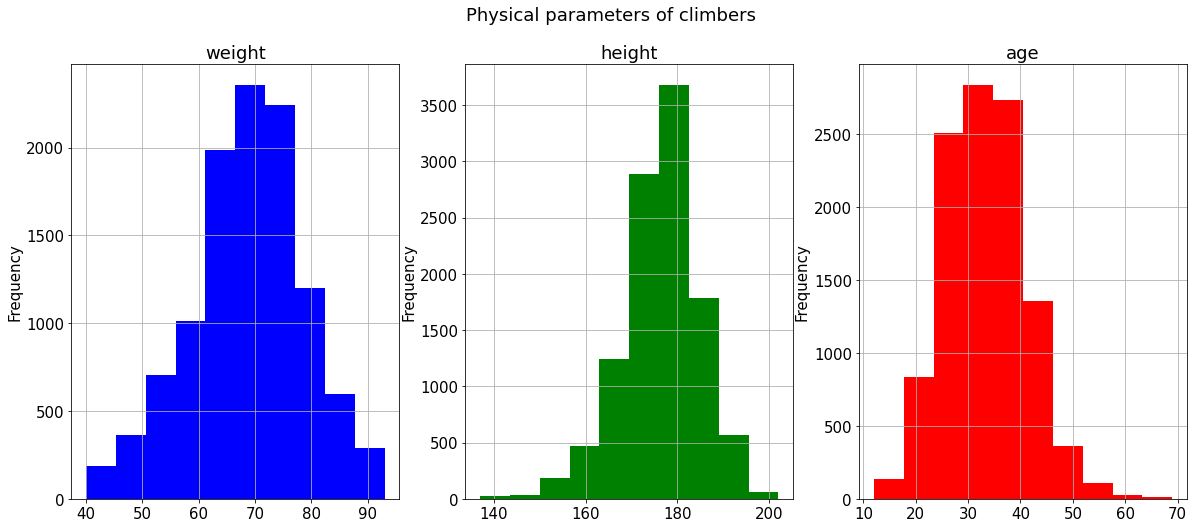

In [8]:
plt.rcParams.update({'font.size': 15, 'figure.figsize': (20, 8)})
plt.subplot(1, 3, 1)
plt.suptitle("Physical parameters of climbers")
escaladors.weight.plot(kind='hist',title = 'weight', grid='True', color='b')
plt.subplot(1, 3, 2)
escaladors.height.plot(kind='hist',title = 'height', grid='True', color='g')
plt.subplot(1, 3, 3)
escaladors.age.plot(kind='hist',title = 'age', grid='True', color='r');

Per al primer exercici, agafo l'atribut "height".

És l'alçada mitjana dels escaladors homes espanyols semblant a l'alçada mitjana dels homes espanyols adults?

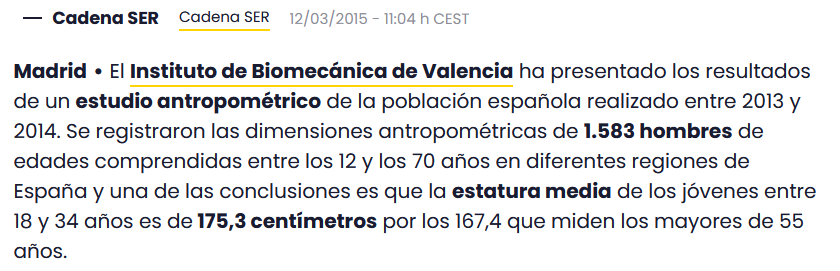

In [9]:
escaladors_home_esp = escaladors[(escaladors.sex == 0) & (escaladors.country == 'ESP')]
escaladors_home_esp.head()

,user_id,country,sex,height,weight,age,years_cl,date_first,date_last,grades_count,grades_first,grades_last,grades_max,grades_mean,year_first,year_last,max_grade
51,308,ESP,0,180,63,36.0,17,2000-02-10 23:00:00,2003-04-19 22:00:00,26,62,70,72,67.769231,2000,2003,14
151,821,ESP,0,170,68,37.0,21,2000-08-21 22:00:00,2013-12-12 23:00:00,214,51,62,68,57.046729,2000,2013,13
187,1051,ESP,0,159,48,36.0,21,2001-07-31 22:00:00,2017-08-19 22:00:00,614,70,62,77,66.237785,2001,2017,15
207,1197,ESP,0,180,58,36.0,17,2000-12-31 23:00:00,2002-03-10 23:00:00,4,49,46,49,45.500000,2001,2002,9
217,1263,ESP,0,174,68,37.0,27,2000-11-03 23:00:00,2015-06-19 22:00:00,108,64,62,77,66.898148,2000,2015,15


In [10]:
escaladors_home_esp.height.describe()

count    1145.000000
mean      176.261135
std         7.016148
min       138.000000
25%       172.000000
50%       176.000000
75%       181.000000
max       200.000000
Name: height, dtype: float64

Aplico el mètode de la T-Student (funció ttest_1samp de scipy.stats) i α = 0.05 per a veure si aquesta mostra pot pertànyer a una població de mitjana 175,3.
    H0: μ = 175,3     l'alçada mitjana dels escaladors homes espanyols es 175,3 cm
    H1: μ ≠ 175,3     l'alçada mitjana dels escaladors homes espanyols es diferent de 175,3 cm

In [11]:
alpha = 0.05
stat, p = ttest_1samp(escaladors_home_esp.height, popmean=175.3)

print(f't-statistic = {stat:.3f}\np-value = {p:.10f}')
print('I can not reject null hypothesis H0') if p > alpha else print('I can reject null hypothesis H0')

t-statistic = 4.635
p-value = 0.0000039716
I can reject null hypothesis H0


Com a exercici, calculo la t manualment. Afortunadament em surt el mateix resultat :)

In [12]:
mitja_pob = 175.3
mitja_samp = escaladors_home_esp.height.mean()
std_dev_samp = escaladors_home_esp.height.std()
sample_size = escaladors_home_esp.height.count()

# formula: 
t = (mitja_samp - mitja_pob) / (std_dev_samp/((sample_size-1)**0.5))
print(t)

4.633389892068516


LLAVORS: Amb una confiança del 95% els escaladors homes espanyols tenen una alçada mitjana diferent de la que hem establert com alçada mitjana dels homes espanyols, 175,3 cm

### *Exercici 2*: Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona dos altres atributs del conjunt de dades. Calcula els p-valors i digues si rebutgen la hipòtesi nul·la agafant un alfa de 5%.

Ara selecciono els atributs "grades_mean" i "sex".

Vull estudiar amb les dades de que disposo si l'escalada pertany als esports on el rendiment esportiu és diferent entre homes i dones. Aquesta diferència de rendiment pot tenir raons fisiològiques, psicològiques i sociològiques.

In [13]:
escaladors.groupby('sex').grades_mean.agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
sex,,,,,,
0,9560,28.5,75.272727,45.858847,45.602469,7.854757
1,1367,28.5,67.500000,43.030836,42.101695,7.703872


Proposo com a hipòtesi que les mitjanes assolides per homes i dones no son iguals. Llavors:

    H0: les mitjanes de "grades_mean" son iguals
    H1: les mitjanes de "grades_mean" no són iguals

In [14]:
escaladors_dones = escaladors[(escaladors.sex == 1)]
escaladors_homes = escaladors[(escaladors.sex == 0)]

- Tinc una diferència de les mitjanes de grades_mean entre homes i dones de 45.86 - 43.03 = 2.83. La desviació estandar de totes dues submostres es d'un ordre de magnitud molt similar.
- Comparo totes dues mostres amb el mètode del t-test de Student (funció *ttest_ind* de *scipy.stats*) i α = 0.05
- Em dona un p-value ≈ 0 < α , consistent amb la hipòtesi H1 de que hi ha una diferència significativa entre el grau mitjà assolit per homes i per dones.

In [15]:
escaladors_dones.grades_mean.describe()

count    1367.000000
mean       43.030836
std         7.703872
min        28.500000
25%        36.896429
50%        42.101695
75%        48.826464
max        67.500000
Name: grades_mean, dtype: float64

In [16]:
escaladors_homes.grades_mean.describe()

count    9560.000000
mean       45.858847
std         7.854757
min        28.500000
25%        39.866216
50%        45.602469
75%        51.480261
max        75.272727
Name: grades_mean, dtype: float64

In [17]:
alpha = 0.05
stat, p = ttest_ind(escaladors_dones.grades_mean, escaladors_homes.grades_mean, equal_var=True)
print(f'stat: {stat:.4}, p: {p}, alpha:{alpha}')
if p > alpha:
    print('p > alpha : H0 cannot be refused. Probably the same distribution')
else:
    print('p < alpha : H0 can be refused. Probably different distributions')

stat: -12.48, p: 1.6562881878290722e-35, alpha:0.05
p < alpha : H0 can be refused. Probably different distributions


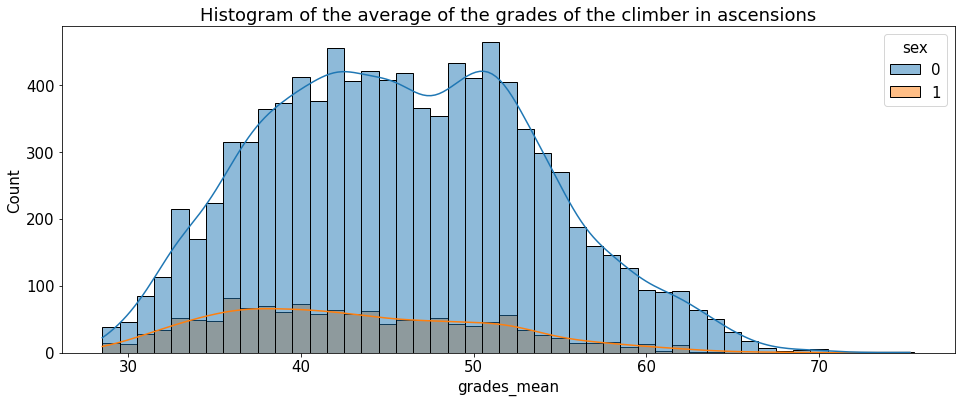

In [18]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors, x='grades_mean', binwidth=1, hue='sex', kde = 'True')
plt.title('Histogram of the average of the grades of the climber in ascensions');
plt.xlabel('grades_mean');

Una reflexió que trec després d'aquests dos primers exercicis es que quan n = nombre de mostres es molt gran, com és el cas, si hi ha una diferencia de les mitjanes -per petita que sigui- es ben probable que rebutgem la hipòtesi nul·la.

Veiem un cas diferent, amb n molt més petits: analitzo les diferencies entre països. És el grau mitjà dels escaladors belgues diferent del grau mitjà dels escaladors finlandesos?

Les mitjanes de les dues mostres son 45.67 (Belgica) i 43.65 (Finlandia). Hi ha 173 mostres per a Bèlgica i 58 per a Finlandia.

    H0: les mitjanes de "grades_mean" de Belgues i Finlandesos son iguals
    H1: les mitjanes de "grades_mean" de Belgues i Finlandesos no són iguals
    
 Repetim el mateix test i veiem que en aquest cas NO podem rebutjar la hipòtesi nul.la.

In [19]:
escaladors.groupby('country').grades_mean.agg(['count','min','max','mean','median','std'])

,count,min,max,mean,median,std
country,,,,,,
AUS,244,29.000000,63.750000,47.407943,47.879710,7.571205
AUT,337,29.000000,66.449541,46.649843,46.540541,8.340974
BEL,176,29.000000,65.012048,45.679941,45.657191,8.778291
BRA,427,29.000000,63.174603,44.648069,44.166667,5.860631
CAN,306,29.000000,64.909091,46.264048,46.420251,7.568862
CHE,225,29.000000,68.666667,47.116795,47.500000,7.555674
CZE,78,30.333333,66.048316,52.193234,53.885870,9.064005
DEU,505,28.500000,69.571429,46.432602,46.370558,7.927842
DNK,119,30.666667,57.888889,43.284274,43.031250,6.164809


In [20]:
escaladors_BEL = escaladors[(escaladors.country == 'BEL')]
escaladors_FIN = escaladors[(escaladors.country == 'FIN')]

In [21]:
escaladors_BEL.grades_mean.describe()

count    176.000000
mean      45.679941
std        8.778291
min       29.000000
25%       38.592531
50%       45.657191
75%       52.086094
max       65.012048
Name: grades_mean, dtype: float64

In [22]:
escaladors_FIN.grades_mean.describe()

count    58.000000
mean     43.651125
std       7.731217
min      31.642857
25%      37.678571
50%      41.978873
75%      49.000000
max      67.000000
Name: grades_mean, dtype: float64

In [23]:
alpha = 0.05
stat, p = ttest_ind(escaladors_BEL.grades_mean, escaladors_FIN.grades_mean, equal_var=True)
print(f'stat: {stat:.4}, p: {p}, alpha:{alpha}')
if p > alpha:
    print('p > alpha : H0 cannot be refused. Probably the same distribution')
else:
    print('p < alpha : H0 can be refused. Probably different distributions')

stat: 1.57, p: 0.11768872733400497, alpha:0.05
p > alpha : H0 cannot be refused. Probably the same distribution


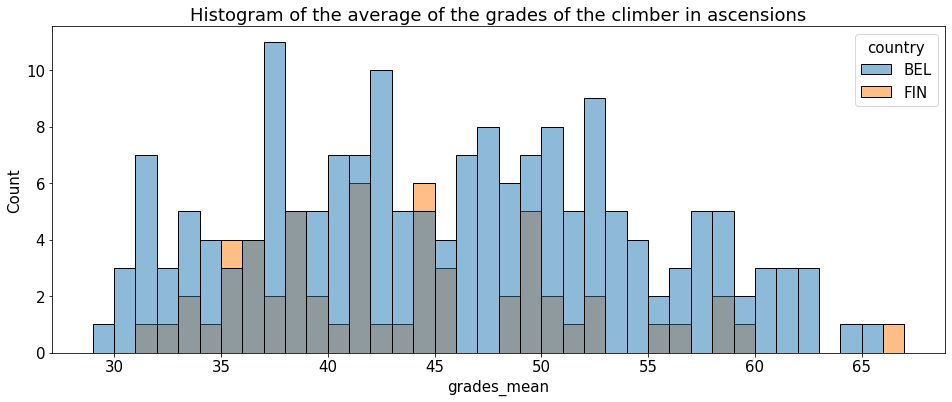

In [24]:
plt.figure(figsize=(16, 6))
sns.histplot(data=escaladors[(escaladors.country == 'BEL')|(escaladors.country == 'FIN')], x='grades_mean', binwidth=1, hue='country')
plt.title('Histogram of the average of the grades of the climber in ascensions');
plt.xlabel('grades_mean');

### *Exercici 3*: Continua amb el conjunt de dades de tema esportiu que t'agradi i selecciona tres atributs del conjunt de dades. Calcula el p-valor i digues si rebutja la hipòtesi nul·la agafant un alfa de 5%

Ara vaig a explorar la relació entre el grau màxim dels escaladors i els anys d'experiencia. Considero el subset dels escalador experts, amb més de 10 anys d'experiencia escalant.

El grau màxim es relaciona amb la capacitat tècnica de l'escalador. El grau màxim assolit es més gran a mesura que es va guanyant experiència? O bé s'arriba a un límit, a partir del qual ja no hi ha millora?

Faig tres grups: entre 10 i 15 anys d'experiencia, entre 15 i 20 anys d'experiència, més de 20 anys d'experiència.

    H0: les μ de les tres mostres són iguals
    H1: les μ de les tres mostres són diferents

In [25]:
escaladors_10_15 = escaladors[(escaladors.years_cl > 10) & (escaladors.years_cl <= 15)]
escaladors_15_20 = escaladors[(escaladors.years_cl > 15) & (escaladors.years_cl <= 20)]
escaladors_gt20 = escaladors[(escaladors.years_cl > 20)]

In [26]:
escaladors_10_15.max_grade.describe()

count    2932.000000
mean       10.402456
std         1.855318
min         5.000000
25%         9.000000
50%        11.000000
75%        12.000000
max        15.000000
Name: max_grade, dtype: float64

In [27]:
escaladors_15_20.max_grade.describe()

count    2047.000000
mean       10.922325
std         1.868430
min         5.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        15.000000
Name: max_grade, dtype: float64

In [28]:
escaladors_gt20.max_grade.describe()

count    1358.000000
mean       11.359352
std         1.667814
min         5.000000
25%        10.250000
50%        11.000000
75%        12.000000
max        15.000000
Name: max_grade, dtype: float64

Comparo totes tres submostres amb el mètode test d'anàlisi de variança (ANOVA) (funció *f_oneway* de *scipy.stats*) i α = 0.05
Em dona un p-value ≈ 0 < α , consistent amb la hipòtesi H1 de que hi ha una diferència significativa entre les tres mitjanes. Rebutjo la hipòtesi nul.la: amb un 95% de confiança les mitjanes del grau maxim assolit són diferents pels tres grups analitzats.

In [29]:
alpha = 0.05
stat, p = f_oneway(escaladors_10_15.max_grade, escaladors_15_20.max_grade, escaladors_gt20.max_grade)

print(f'F-statistic = {stat:.3f}\np-value = {p:.60f}')
print('We can NOT reject null hypothesis H0') if p > alpha else print('We can reject null hypothesis H0')

F-statistic = 137.959
p-value = 0.000000000000000000000000000000000000000000000000000000000023
We can reject null hypothesis H0


El resultat del test ANOVA ens diu que les 3 mitjanes no són iguals, però poden ser iguals dos a dos? Per això, hem d'aplicar el test de TUKEY (amb la funcio *pairwise_tukeyhsd()* de *statsmodels.stats.multicomp*) i α = 0.05.

Per tal d'aplicar-lo em genero amb una funció una nova columna categòrica segons la experiència en anys de l'escalador,amb *bins* de 5 anys.

Segons els resultats, puc rebutjar amb un nivell de significancia del 5%, que cap dels tres grups d'escaladors té el mateix grau mitjà que un dels altres grups.

In [30]:
def rang(x):
    if x <= 5.0:
        return '0-5 years'
    elif x <= 10.0:
        return '5-10 years'
    elif x <= 15.0:
        return '10-15 years'
    elif x <= 20.0:
        return "15-20 years"
    else:
        return ">20 years"
escaladors['experience'] = escaladors['years_cl'].apply(rang)

In [31]:
subset = escaladors[escaladors.experience.str.match('10-15 years|15-20 years|>20 years')]

alpha = 0.05

print(pairwise_tukeyhsd(endog = subset.max_grade, groups=subset.experience, alpha=0.05))

    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
   group1      group2   meandiff p-adj lower  upper  reject
-----------------------------------------------------------
10-15 years 15-20 years   0.5199 0.001 0.3969 0.6428   True
10-15 years   >20 years   0.9569 0.001 0.8168  1.097   True
15-20 years   >20 years    0.437 0.001 0.2876 0.5864   True
-----------------------------------------------------------


Al propi histograma de les tres submostres s'aprecia molt bé que amb més experiencia el max_grade cada vegada més gran. Certament, un escalador de més de vint anys d'experiencia ja tindrà ben probablement més de 40 anys d'edat, i recordo haver llegit que l'edat de plenitud dels alpinistes és a partir dels quaranta anys. La qual cosa sembla validat per el nostre estudi.

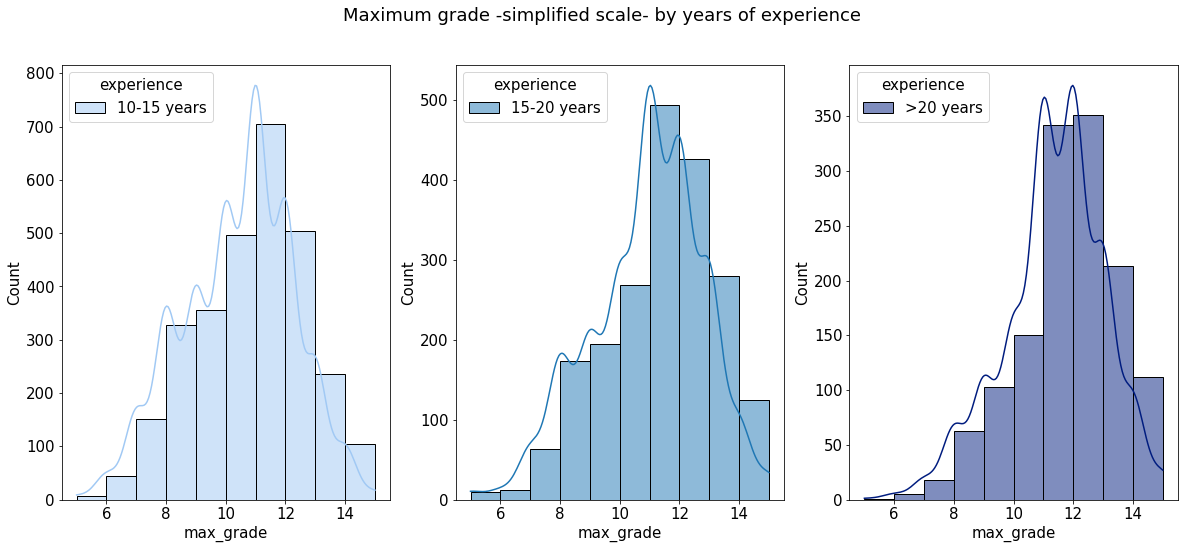

In [32]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)
sns.histplot(data=escaladors[(escaladors.experience == '10-15 years')], x='max_grade', binwidth=1, hue='experience', palette="pastel", kde='True')
plt.subplot(1, 3, 2)
sns.histplot(data=escaladors[(escaladors.experience == '15-20 years')], x='max_grade', binwidth=1, hue='experience', kde='True')
plt.subplot(1, 3, 3)
sns.histplot(data=escaladors[(escaladors.experience == '>20 years')], x='max_grade', binwidth=1, hue='experience', palette="dark", kde='True')
plt.suptitle('Maximum grade -simplified scale- by years of experience');